In [438]:
%matplotlib inline

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, stats
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.regression
import statsmodels.tools



## some datetime conversion warning
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Always make it pretty.
plt.style.use('ggplot')
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})


In [310]:
clinical_lab_df = pd.read_csv("/Users/GuntherUlvanget/Capstone/Capstone2/Influenza/stateFluViewPhase2Data 2/WHO_NREVSS_Clinical_Labs.csv",header = 1, na_values = 'X', na_filter = True)

In [311]:
#not all states report weekly public health data. convert the X to na and drop

clinical_lab_df.dropna(axis = 0, inplace = True)
clinical_lab_df.head()

,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,TOTAL A,TOTAL B,PERCENT POSITIVE,PERCENT A,PERCENT B
0,States,Alabama,2015,40,167.0,2.0,3.0,2.99,1.20,1.80
2,States,Arizona,2015,40,55.0,0.0,0.0,0.00,0.00,0.00
3,States,Arkansas,2015,40,26.0,0.0,1.0,3.85,0.00,3.85
4,States,California,2015,40,683.0,2.0,0.0,0.29,0.29,0.00
5,States,Colorado,2015,40,255.0,0.0,1.0,0.39,0.00,0.39


In [312]:
clinical_lab_df["date"] = pd.to_datetime(clinical_lab_df.YEAR.astype(str), format='%Y') + \
             pd.to_timedelta(clinical_lab_df.WEEK.mul(7).astype(str) + ' days')

In [313]:
#clinical_lab_df.drop(columns = ["REGION TYPE","YEAR","WEEK", "PERCENT POSITIVE", "PERCENT A","PERCENT B"], inplace = True)
clinical_lab_df.head()

,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,TOTAL A,TOTAL B,PERCENT POSITIVE,PERCENT A,PERCENT B,date
0,States,Alabama,2015,40,167.0,2.0,3.0,2.99,1.20,1.80,2015-10-08
2,States,Arizona,2015,40,55.0,0.0,0.0,0.00,0.00,0.00,2015-10-08
3,States,Arkansas,2015,40,26.0,0.0,1.0,3.85,0.00,3.85,2015-10-08
4,States,California,2015,40,683.0,2.0,0.0,0.29,0.29,0.00,2015-10-08
5,States,Colorado,2015,40,255.0,0.0,1.0,0.39,0.00,0.39,2015-10-08


In [314]:
combined_labs_pre_2015_df = pd.read_csv("/Users/GuntherUlvanget/Capstone/Capstone2/Influenza/stateFluViewPhase2Data 2/WHO_NREVSS_Combined_prior_to_2015_16.csv",  header = 1, na_values = 'X', na_filter = True)

combined_labs_pre_2015_df.dropna(axis = 0, inplace = True)
combined_labs_pre_2015_df.head()

,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,PERCENT POSITIVE,A (2009 H1N1),A (H1),A (H3),A (Subtyping not Performed),A (Unable to Subtype),B,H3N2v
0,States,Alabama,2010,40,54.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,States,Alaska,2010,40,40.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,States,Arizona,2010,40,40.0,2.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,States,Arkansas,2010,40,15.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,States,California,2010,40,183.0,3.28,2.0,0.0,3.0,0.0,0.0,1.0,0.0


In [315]:
combined_labs_pre_2015_df["TOTAL A"]= pd.to_numeric(combined_labs_pre_2015_df["A (2009 H1N1)"]) + pd.to_numeric(combined_labs_pre_2015_df["A (H3)"]) + pd.to_numeric(combined_labs_pre_2015_df["A (Subtyping not Performed)"]) + pd.to_numeric(combined_labs_pre_2015_df["A (Unable to Subtype)"])+ pd.to_numeric(combined_labs_pre_2015_df ["A (H1)"]) 

In [316]:
combined_labs_pre_2015_df["TOTAL B"]= pd.to_numeric(combined_labs_pre_2015_df["H3N2v"]) +  pd.to_numeric(combined_labs_pre_2015_df["B"])

In [317]:
combined_labs_pre_2015_df["date"] =  pd.to_datetime(combined_labs_pre_2015_df.YEAR.astype(str), format='%Y') + \
             pd.to_timedelta(combined_labs_pre_2015_df.WEEK.mul(7).astype(str) + ' days')

In [322]:
##combined_labs_pre_2015_df.drop(columns= ["REGION TYPE","A (2009 H1N1)", "A (H3)" ,"H3N2v",  "B","A (Subtyping not Performed)","YEAR","WEEK", "PERCENT POSITIVE", "A (H1)",  "A (Unable to Subtype)"], inplace = True)
combined_labs_pre_2015_df.head()

,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,PERCENT POSITIVE,A (2009 H1N1),A (H1),A (H3),A (Subtyping not Performed),A (Unable to Subtype),B,H3N2v,TOTAL A,TOTAL B,date
0,States,Alabama,2010,40,54.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-10-08
1,States,Alaska,2010,40,40.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-10-08
2,States,Arizona,2010,40,40.0,2.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2010-10-08
3,States,Arkansas,2010,40,15.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-10-08
4,States,California,2010,40,183.0,3.28,2.0,0.0,3.0,0.0,0.0,1.0,0.0,5.0,1.0,2010-10-08


In [319]:
# removed public_health_lad_df,
ten_year_influenza_confirmed = pd.concat([combined_labs_pre_2015_df,clinical_lab_df], sort=False)

In [327]:
ten_year_influenza_confirmed['Confirmed_Infections'] = ten_year_influenza_confirmed["TOTAL A"] + ten_year_influenza_confirmed["TOTAL B"]

number_colors=len(ten_year_influenza_confirmed.REGION.unique())


In [467]:
total_infections =ten_year_influenza_confirmed.groupby(["date"]).sum()
mean_total_infections = ten_year_influenza_confirmed.groupby(["date"]).mean()

total_infections.reset_index(inplace=True)
mean_total_infections.reset_index(inplace = True)



,date,YEAR,WEEK,TOTAL SPECIMENS,PERCENT POSITIVE,A (2009 H1N1),A (H1),A (H3),A (Subtyping not Performed),A (Unable to Subtype),B,H3N2v,TOTAL A,TOTAL B,PERCENT A,PERCENT B,Confirmed_Infections
0,2010-10-08,82410,1640,3200.0,56.34,7.0,0.0,16.0,13.0,0.0,9.0,0.0,36.0,9.0,0.0,0.0,45.0
1,2010-10-15,80400,1640,3501.0,57.98,11.0,0.0,27.0,11.0,0.0,18.0,0.0,49.0,18.0,0.0,0.0,67.0
2,2010-10-22,84420,1764,3572.0,61.18,7.0,0.0,24.0,8.0,0.0,23.0,0.0,39.0,23.0,0.0,0.0,62.0
3,2010-10-29,84420,1806,3702.0,80.12,13.0,0.0,37.0,15.0,0.0,23.0,0.0,65.0,23.0,0.0,0.0,88.0
4,2010-11-05,86430,1892,4028.0,105.05,11.0,0.0,45.0,21.0,0.0,57.0,0.0,77.0,57.0,0.0,0.0,134.0


In [457]:
# the following states have higher morbidity rates due to influenza than the nations averag of 13.5 per 100,000. We will examin them first
states_of_interest=["Hawaii"," Mississippi", "Tennessee","New York","Nevada","Kentucky","West Virginia","Alabama", "Arkansas"] 

ten_year_influenza_confirmed.columns

Index(['REGION TYPE', 'REGION', 'YEAR', 'WEEK', 'TOTAL SPECIMENS',
       'PERCENT POSITIVE', 'A (2009 H1N1)', 'A (H1)', 'A (H3)',
       'A (Subtyping not Performed)', 'A (Unable to Subtype)', 'B', 'H3N2v',
       'TOTAL A', 'TOTAL B', 'date', 'PERCENT A', 'PERCENT B',
       'Confirmed_Infections'],
      dtype='object')

In [415]:

group1 = ten_year_influenza_confirmed.REGION.unique()[0:10]
group2 = ten_year_influenza_confirmed.REGION.unique()[10:20]
group3 = ten_year_influenza_confirmed.REGION.unique()[20:30]
group4 = ten_year_influenza_confirmed.REGION.unique()[30:40]
group5 = ten_year_influenza_confirmed.REGION.unique()[40:]
groups= [group1,group2, group3, group4, group5]

In [420]:
group_states = []
for i,j in enumerate(groups):
    mask_list = [ten_year_influenza_confirmed["REGION"] == state for state in j ] 
    state_df= [ten_year_influenza_confirmed[masked] for masked in mask_list]
    group_states.append( pd.concat(state_df))

[None, None, None, None, None]

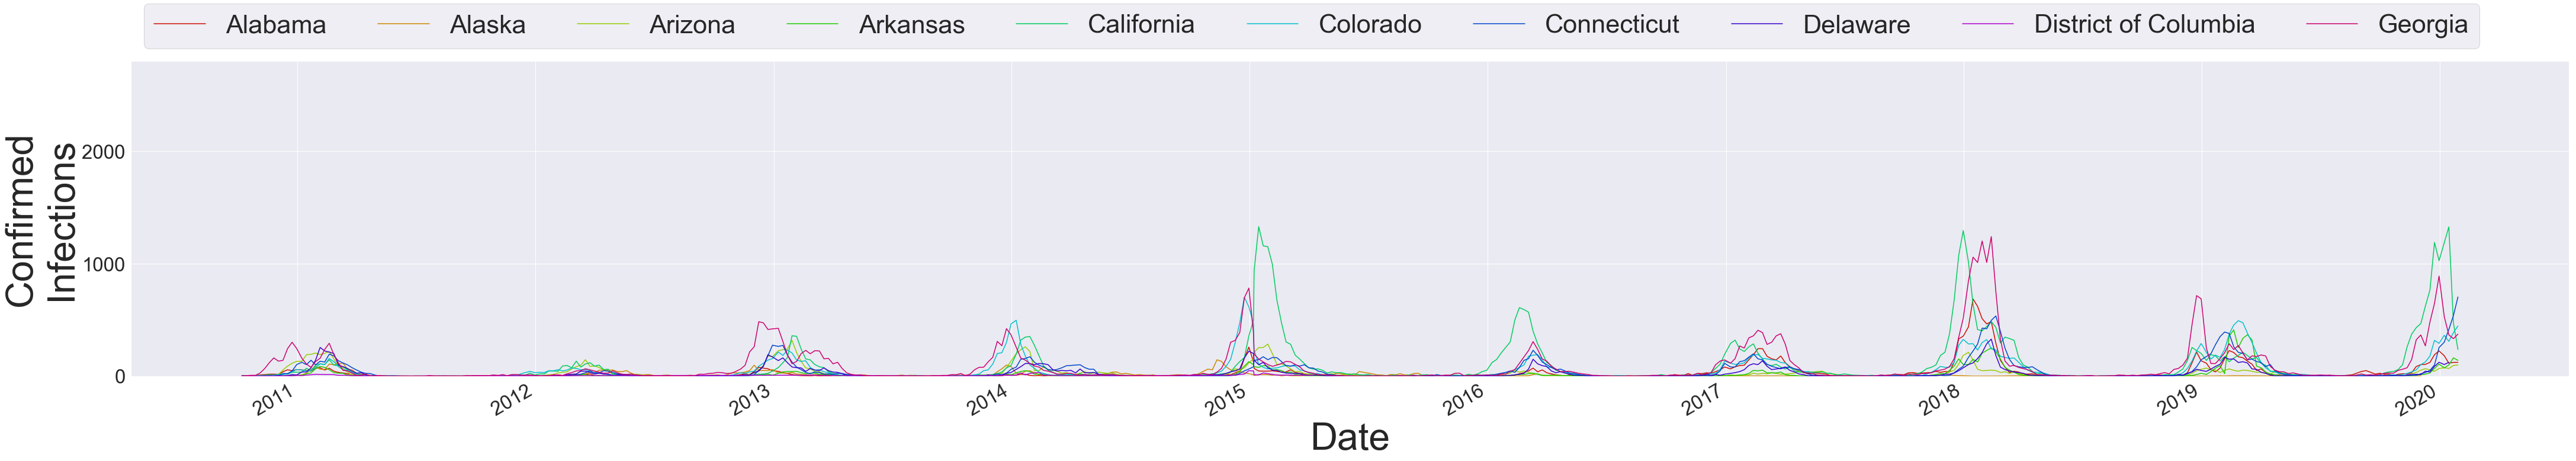

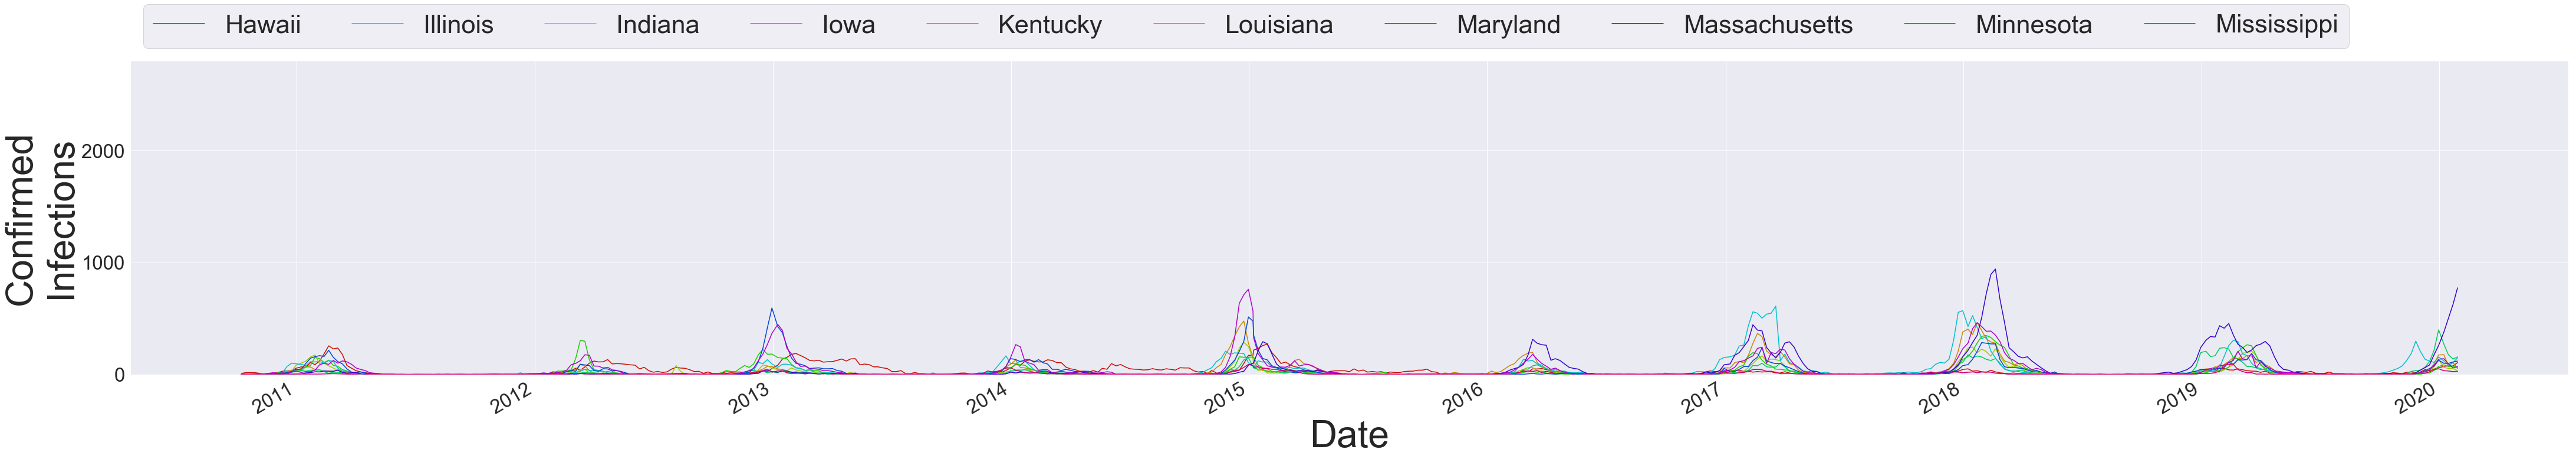

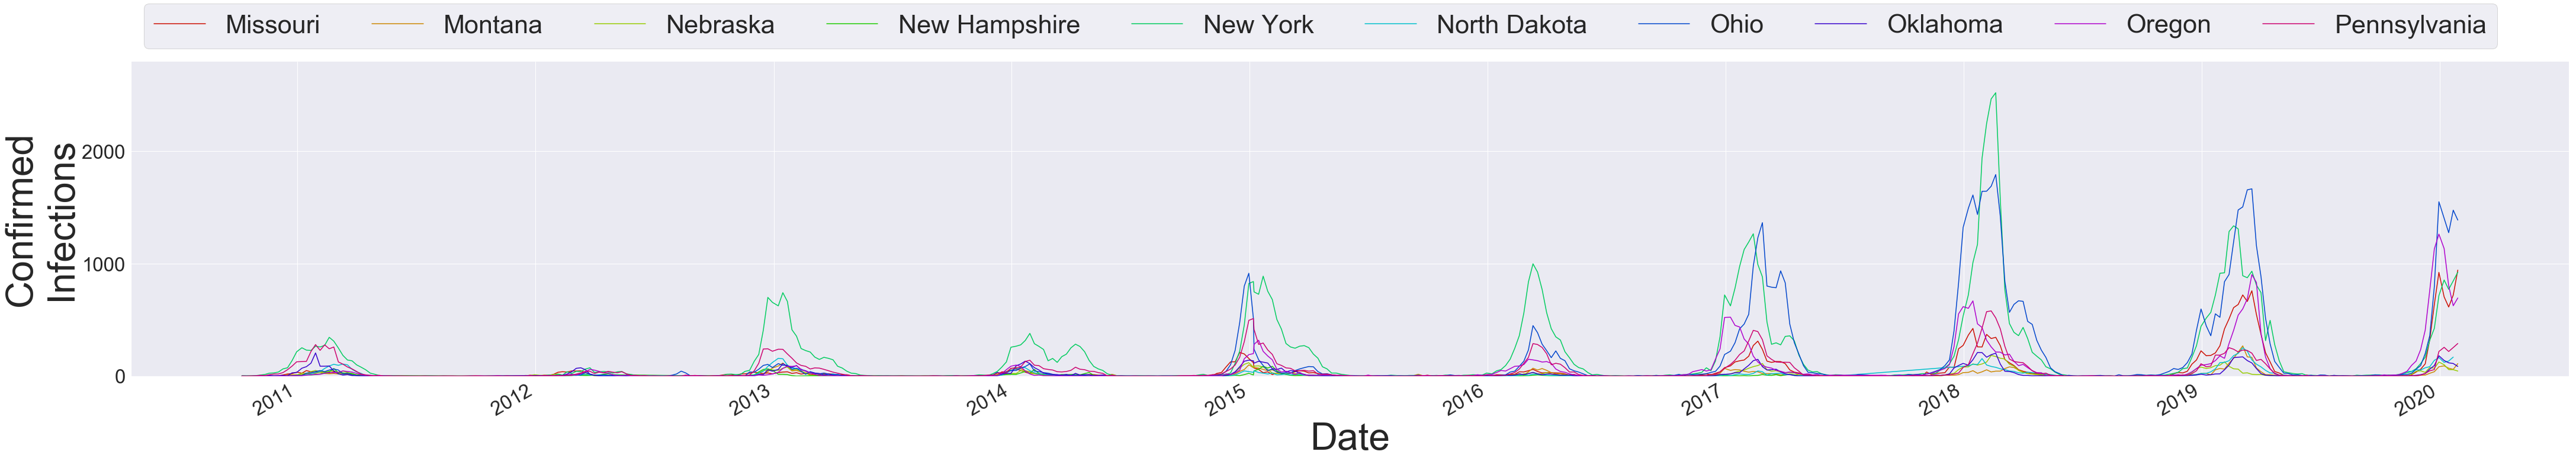

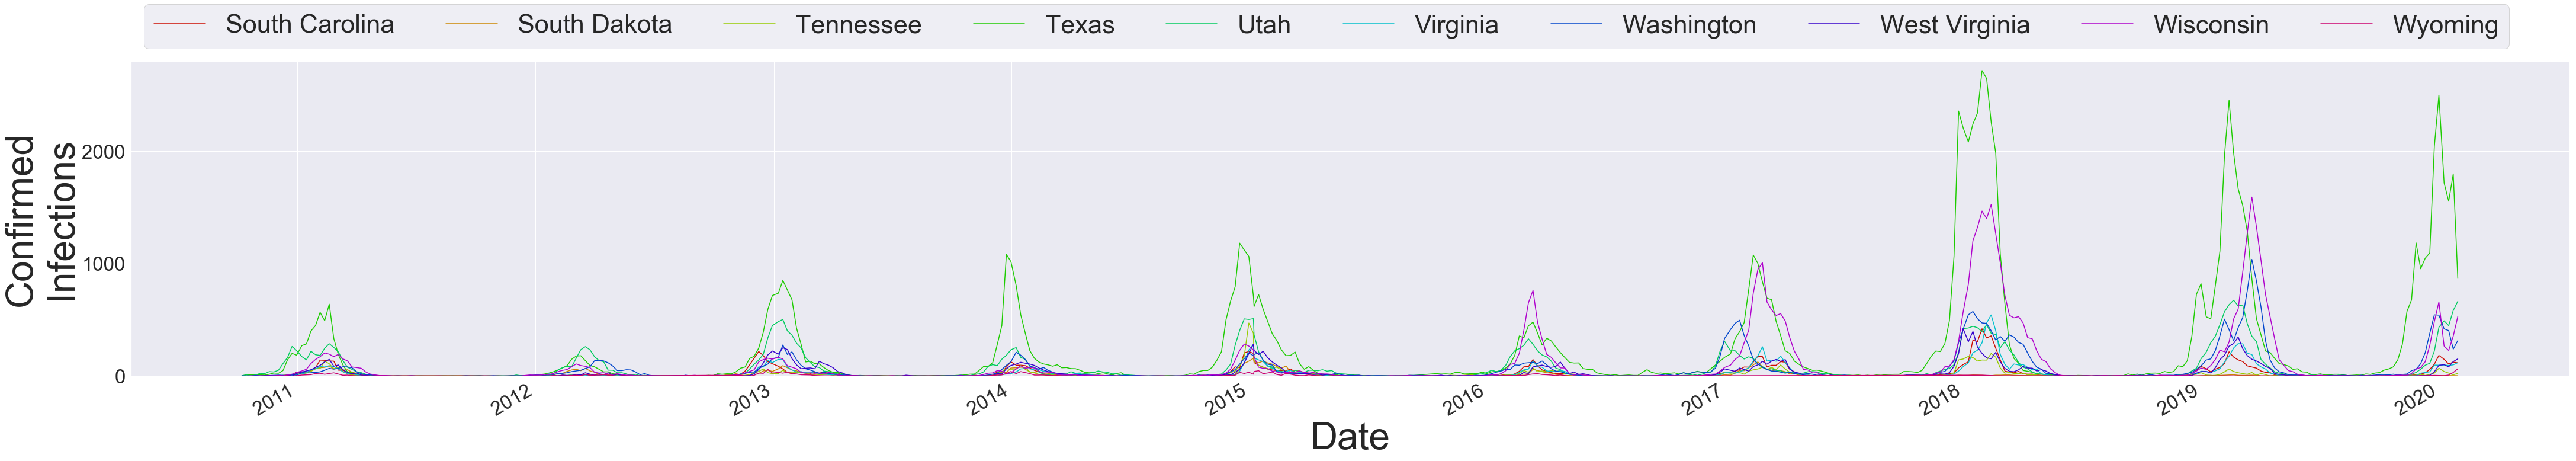

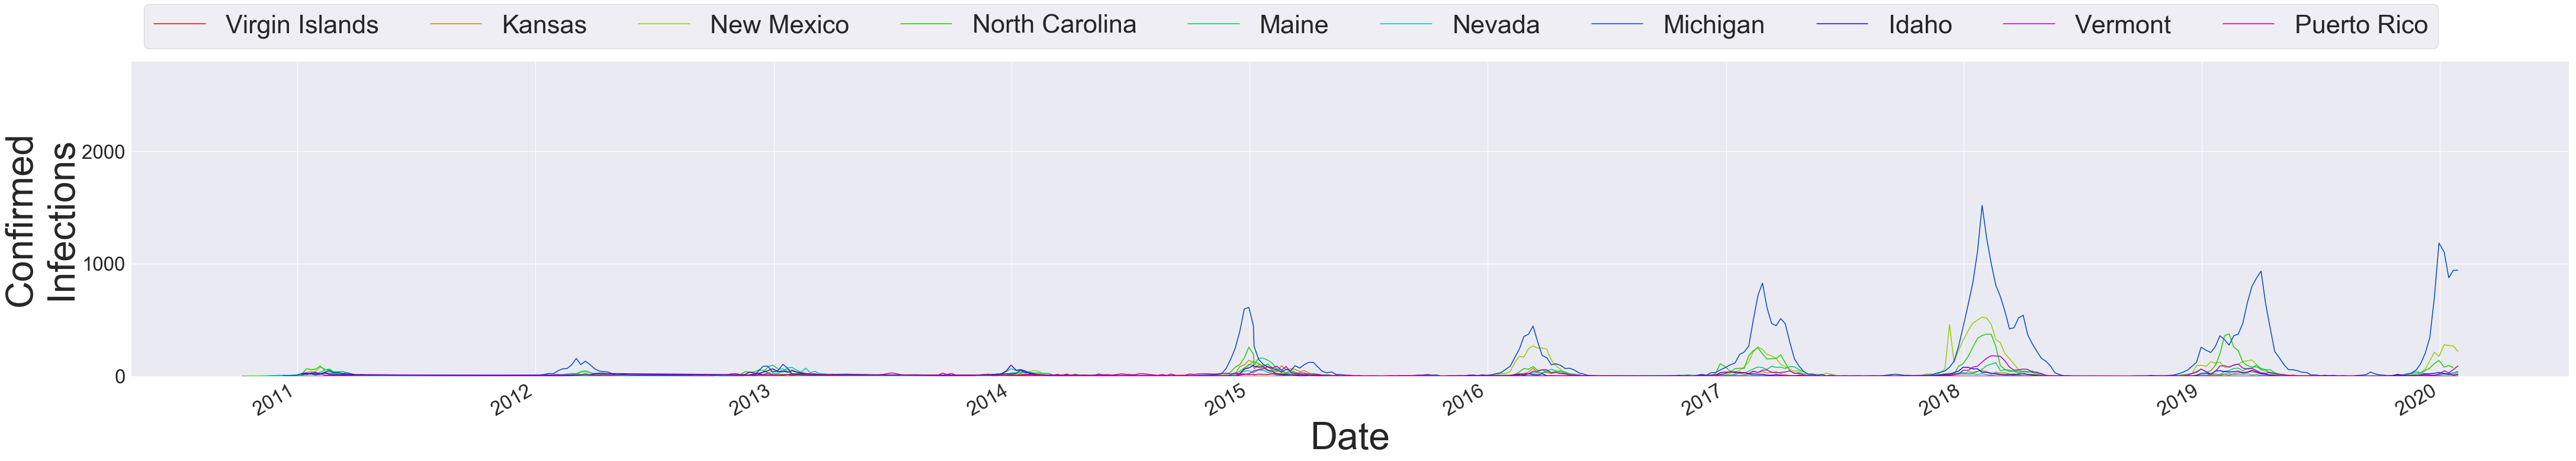

In [455]:
def graph_states(df):
    
    sns.set_context("poster")

   
    number_colors=len(df.REGION.unique())
    labels = df.REGION.unique()
    sns.set(font_scale=3)
    g = sns.relplot(x="date", 
                    y="Confirmed_Infections", 
                    hue ="REGION", kind="line", 
                    data=df, 
                    height=10, 
                    aspect=6,
                    palette=sns.hls_palette(number_colors, l=.4, s=1),
                   legend=False)
    sns.set_context("poster")



    plt.legend(labels, ncol=10, bbox_to_anchor=(0, 1),
                  loc='lower left', fontsize='large')
    g.fig.autofmt_xdate()
    sns.set(font_scale=5)
    plt.ylim(0,2800) 
    plt.ylabel("Confirmed\nInfections", fontsize=64) 
    plt.xlabel("Date", fontsize=64)
    plt.plot()

    plt.savefig(df.REGION.unique()[0], bbox_inches = "tight") 
[graph_states(group) for group in group_states] 




[]

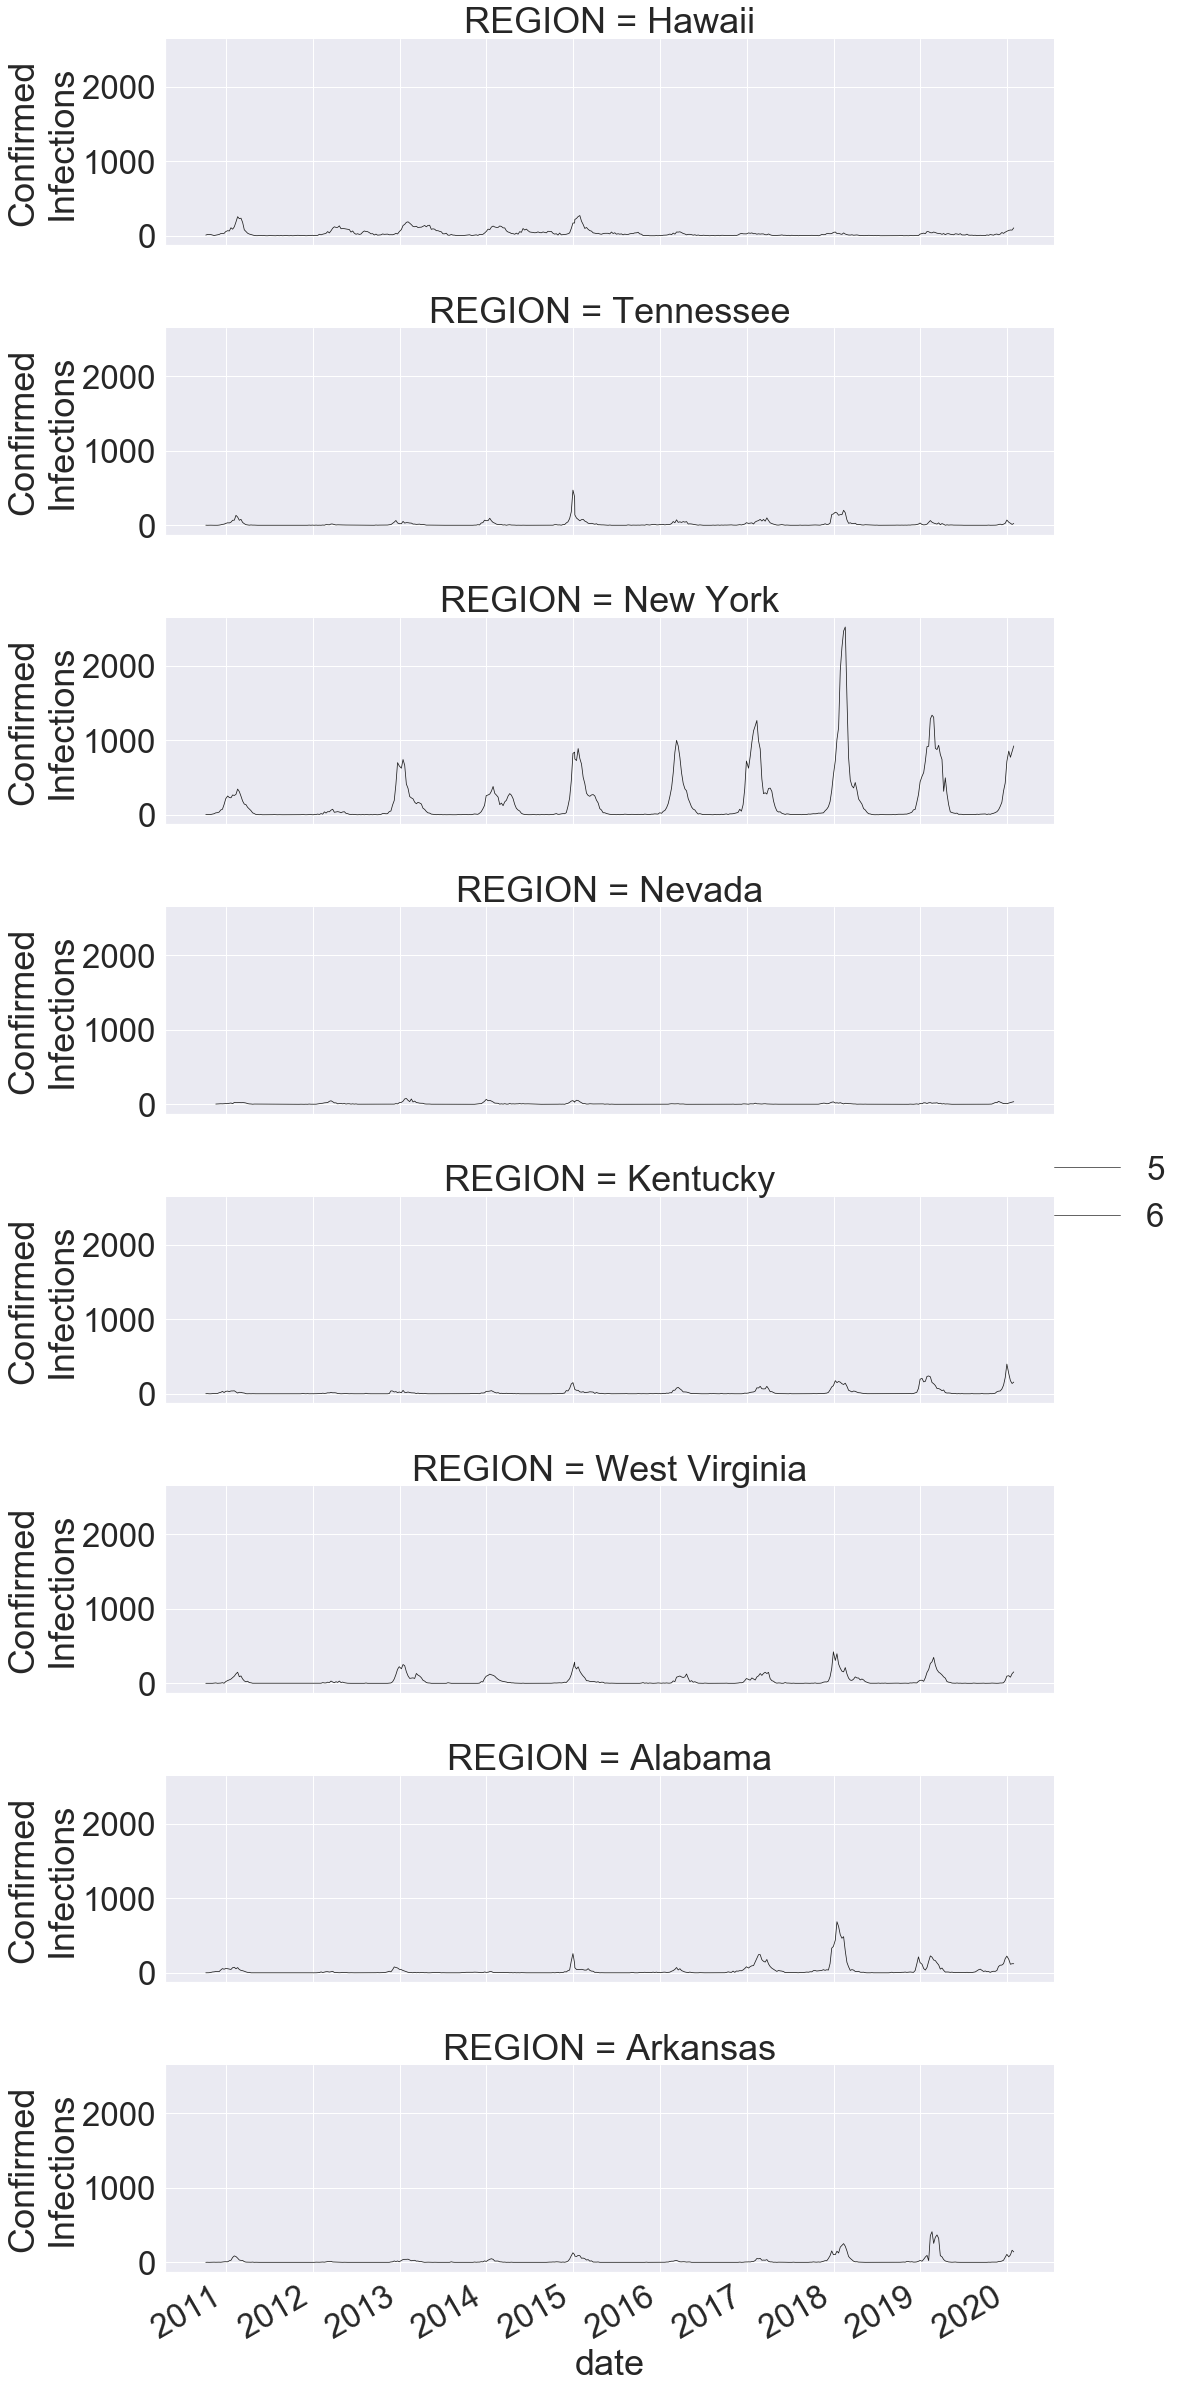

In [304]:
state_df= [ten_year_influenza_confirmed[masked] for masked in mask_list]
influenza_deadly_states = pd.concat(state_df)
import seaborn as sns

sns.set(font_scale=3)
g = sns.relplot(x="date", y="Confirmed_Infections",  kind="line", data=influenza_deadly_states, size=6, aspect=3,
                color ="k", row = "REGION") 
g.set_ylabels("Confirmed\nInfections") 
#plt.ylabel("Confirmed\nInfections")              
g.fig.autofmt_xdate()

plt.plot()


#.figsize(15,8)

[]

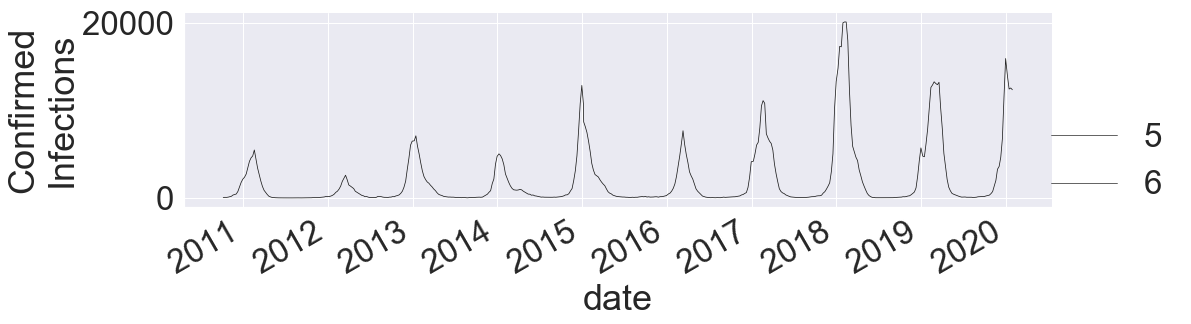

In [470]:
total_infections 

sns.set(font_scale=3)
g = sns.relplot(x="date", y="Confirmed_Infections",  kind="line", data=total_infections , size=6, aspect=3,
                color ="k") 
g.set_ylabels("Confirmed\nInfections") 
#plt.ylabel("Confirmed\nInfections")              
g.fig.autofmt_xdate()

plt.plot()

 Augmented Dickey-Fuller test for stationarity with:

𝐻0 : The series is not-stationary (specifically, has a unit root).
𝐻a : The series is stationary.

In [468]:
test = sm.tsa.stattools.adfuller(total_infections['Confirmed_Infections'])
print("ADF p-value for python series: {0:2.2f}".format(test[1]))

ADF p-value for python series: 0.00


insufficient evidence that it is stationary


In [469]:
test = sm.tsa.stattools.adfuller(total_infections['Confirmed_Infections'].diff()[1:])
print("ADF p-value for differenced python series: {0:2.2f}".format(test[1]))

ADF p-value for differenced python series: 0.00


diferencing helped

In [ ]:
total_infections 